# Face recognition using k-Nearest Neighbor

---

### Contents
<ol>
    <li><a href="#data-preprocessing" style="color: currentColor">Data preprocessing</a></li>
    <li><a href="#pca" style="color: currentColor">Principal Component Analysis</a></li>
    <li><a href="#knn" style="color: currentColor">k-Nearest-Neighbor</a></li>
    <li><a href="#testing" style="color: currentColor">Model testing</a></li>
    <li><a href="#accuracy" style="color: currentColor">Accuracy evaluation</a></li>
    <li><a href="#further-analysis" style="color: currentColor">Further Analysis</a></li>
</ol>
<br>

<i> Note: To keep the notebook readable, it focuses on executing the code and showing the results. The entire code can be found in the functions folder and the beloging .py files.</i>

---

### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.graph_objects as go


# os.chdir(r"C:\Users\fedbe\OneDrive\Dokumente\GitHub\topic01_team01")
# checks if the current working directory is correct:
# print(os.getcwd())

---

## <a id="data-preprocessing"></a> 1. Data preprocessing 

(INSERT SOURCES?) (INCLUDE MORE INFO; e.g. FORMULAS TO DESCRIBE ALL STEPS BETTER?)

In the first part, we need to perform different preprocessing steps before we can move on to Principal component analysis (PCA).\
First, we transform each image into a 1D vector to create a 2D data matrix where each row is a single sample (image) and each column corrresponds to one feature (pixel). This procedure is called <b> flattening</b>.\
Secondly, we <b> convert the integer formats to floating point</b> so that arithmetic operations behave correctly and <b> normalize </b> the data to the range [0,1] to ensure that each pixel has a similar scale.\
Before performing further preprocessing steps, we split the dataset into training and test data. The dataset contains 11 images expressing different facial expression and light conditions of 15 subjects each. In order to split these images, 8 images of each subject are choosen randomly to use for training. All remaining images will serve as test data.
Next, we <b> center our data </b> . This is done, by subtracting the mean value for each pixel position across the dataset. This ensures that your dataset has a zero mean, which is essential because PCA will then capture the directions of maximum variance around this mean.\
Lastly, we <b> standardize</b>  the data by subtracting the mean and then dividing by the standard deviation for each feature (also called <b> z-transformation</b>).

In [2]:
# for MacOS users, the path separator is a forward slash, please uncomment the following line and comment the other one:
# %run functions/preprocessing.py

%run functions\preprocessing.py


Total training images: 120
Total testing images: 45

After preprocessing:
Training data shape: (120, 77760)
Testing data shape: (45, 77760)

Verification of preprocessing:
First training image: Mean ≈ 0.3996, Std ≈ 0.6604


---

## <a id="pca"></a> 2. Pricinpal component analysis

In [3]:
from functions.pca import svd_pca
from functions.pca import pca_transform

n_components = 40  # Number of components to keep, can be adjusted later
# semicolon is used to suppress output of the last line in Jupyter notebooks, so in our case it prevents the return output
projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train,n_components)
test_reduced = pca_transform(final_test,projection_matrix)
# Maybe already implement here some Plots, to show which PC are the most important ones
# and what number of n_components is the best to use for our model instead of doing everything in 5.?
# 

Succesfully reduced Matrix from (120, 77760) to (120, 40)

Succesfully transformed Matrix from (45, 77760) to (45, 40)


---

## <a id="knn"></a> 3. k-Nearest-Neighbor

In [11]:
from functions.knn import knn_classifier

k = 4 # Number of neighbors to consider
predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k)

# Here is a simple example of calculating accuracy:
# test_labels is only needed for evaluating the model
# therefore we check if it exists in the global scope (dictionary of all variables)


# Convert them to NumPy arrays if they aren’t already:
true_labels = np.array(test_labels)
pred_labels = np.array(predictions)

# Compute the confusion matrix. It will have shape (n_classes, n_classes).
cm = confusion_matrix(true_labels, pred_labels)

# Optional: Determine the unique class labels for better tick labeling.
classes = np.unique(np.concatenate((true_labels, pred_labels)))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#            xticklabels=classes, yticklabels=classes, cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title(f"Confusion Matrix for KNN Classification (k = {k})")
# plt.show()


# Create annotation text
annotations = [[str(cm[i][j]) for j in range(len(classes))] for i in range(len(classes))]

# Compute false annotations (misclassified entries)
false_annotations = np.sum(cm) - np.trace(cm)  # Sum of non-diagonal entries

# Compute missing annotations (count where diagonal != 3)
# expected_value = 3  # Expected value on the diagonal
# missing_annotations = np.sum(cm.diagonal() != expected_value)

# Generate heatmap using Plotly
fig = ff.create_annotated_heatmap(z=cm,
                                  x=classes.tolist(),
                                  y=classes.tolist(), 
                                  annotation_text=annotations, colorscale='Blues')
# Set labels
fig.update_layout(title={
        "text": f"Confusion Matrix for KNN Classification (k = {k})<br>"
        f"Total missclassified Images: {false_annotations}",
        "y": 0.925,  # Adjust the vertical position (higher value moves it further up)
        "x": 0.5,   # Keep it centered
        "xanchor": "center",
        "yanchor": "top"},
    xaxis_title="Predicted Labels", 
    yaxis_title="True Labels",
    autosize=False, 
    width=900,
    height=650,
    xaxis=dict(side="bottom")
)
fig.show()

k-NN Classification Accuracy: 77.78%


---

## <a id="testing"></a> 4. Model testing

In [5]:
img_check = Image.open("datasets/subject01.glasses.gif")
print(f"Size: {img_check.size}")

Size: (320, 243)


final_test shape: (45, 77760)
test_images original shape: (45, 243, 320)
Total misclassified images found: 10
[1, 5, 14, 18, 20, 21, 22, 24, 41, 43]


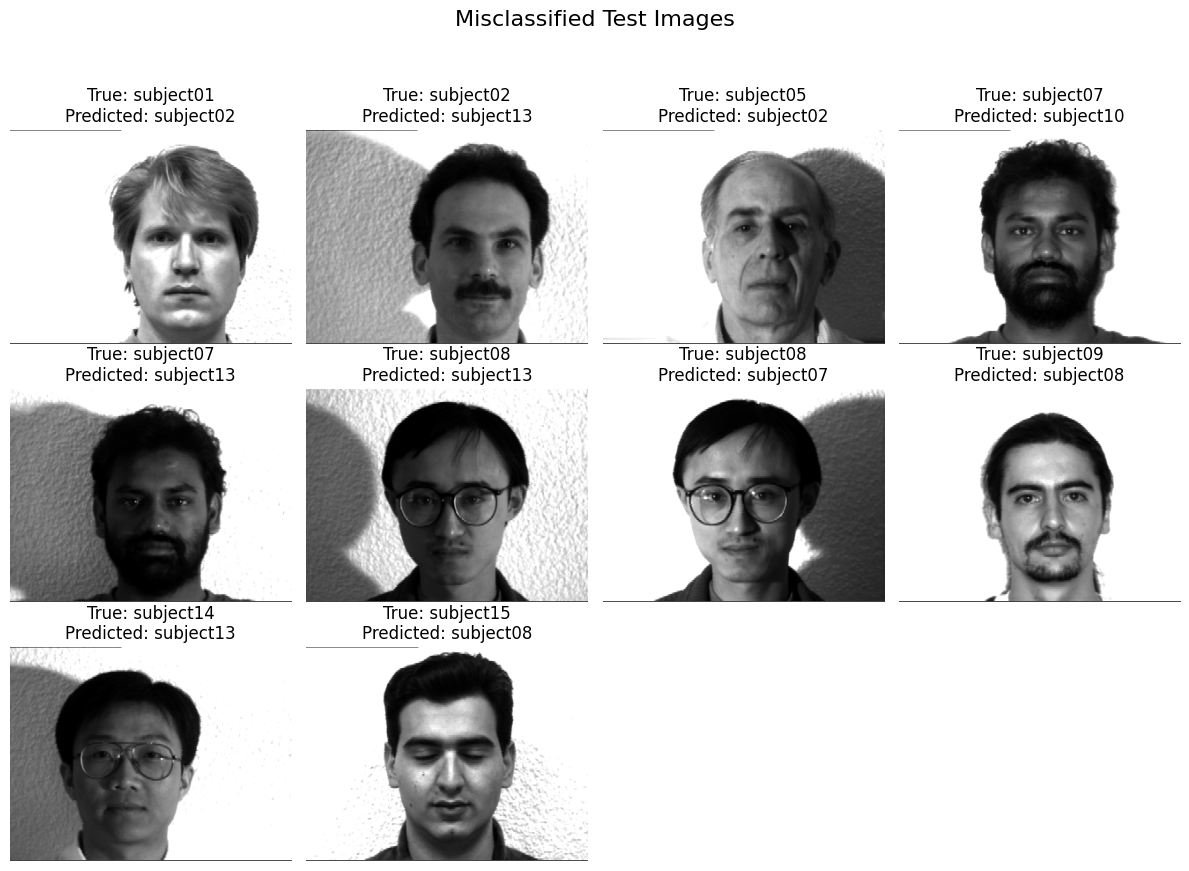

In [6]:
# first we rescale the image to the original size of the training images
image_height = 243
image_width = 320
original_shape_test_images = test_arr.reshape(-1, image_height, image_width)
print(f"final_test shape: {test_arr.shape}")
print(f"test_images original shape: {original_shape_test_images.shape}")

# Determine misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predictions)) if true != pred]
# Print the number of misclassified images and their indices
print(f"Total misclassified images found: {len(misclassified_indices)}")
print(misclassified_indices)
# Let's plot up to 16 misclassified images (or fewer if not available)
num_to_plot = min(16, len(misclassified_indices))
# for this a plot with subplots is created
plt.figure(figsize=(12, 12))
for idx, mis_idx in enumerate(misclassified_indices[:num_to_plot]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(original_shape_test_images[mis_idx], cmap='gray') # assuming grayscale images
    plt.title(f"True: {test_labels[mis_idx]}\nPredicted: {predictions[mis_idx]}")
    plt.axis('off')
plt.suptitle("Misclassified Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---

## <a id="accuracy"></a> 5. Accuracy evaluation

In section 5 we perform some evaluations in order to optimize our output. As we ran our model before for demonstration, we already used the best parameters based on the evaluations below. Therefore, this section will show why the chosen parameters are the best for our Image analysis model.

### 5.1  How to split the dataset?

The results depend on the way you choose to split the dataset. If you use not enough images for testing, the model might not recongnize unseen images correctly. TEXT ERWEITERN
Therefore, we evaluated what kind of splitting is the most efficient one: 


durchlaufen lassen für accuracy gegen anzahl der train images als plot => scatter plot oder boxplot

### 5.2 Finding perfect amount of principal components

After evaluating the dataset splitting, we now want to find out which amount of pricipal components (PC) is the one with the highest accuracy and fast data processing. We defined a threshold of ... % to be the perfect variance. Therefore we choose .... PCs. The curve shows a horizontal asymptotic behavior. It increases exponentially in the beginning. As the number of components increases, the cumulative explained variance ratio continues to grow, but at a slower rate.

In [7]:
projection_matrix_for_plot, train_reduced_for_plot, explained_variance_ratio_for_plot = svd_pca(final_train,100)

n_pcs_for_plot = np.arange(1, 101)  # Range of components from 1 to 100

cumulative_variance = np.cumsum(explained_variance_ratio_for_plot)
# Normalize to percentages such that the total is 100%
cumulative_variance_norm = cumulative_variance / cumulative_variance[-1] * 100

#zip is used to create a list of hover texts for each point
#it works by combining the number of PCs and the corresponding cumulative variance
hover_texts = [f"PC: {x}<br>Cumulative Variance: {y:.2f}%" if x != 40 else "" for x, y in zip(n_pcs_for_plot, cumulative_variance_norm)]

# Create the main trace for the curve
curve_trace = go.Scatter(
    x=n_pcs_for_plot,
    y=cumulative_variance_norm,
    mode='lines+markers',
    name='Cumulative Variance Curve',
    hoverinfo ='text',
    text=hover_texts
)

# Highlight the point at 40 PCs by adding an extra trace
highlight_trace = go.Scatter(
    x=[n_components],  # x-coordinate at n PCs
    y=[cumulative_variance_norm[n_components-1]],  # corresponding cumulative variance
    mode='markers',
    name=f'Amount of PCs chosen ({n_components})',
    marker=dict(size=10, color='red'),
    hovertemplate='PC: %{x}<br>Cumulative Variance: %{y:.2f}%<extra></extra>'
)
# Create the plot
fig = go.Figure(data=[curve_trace, highlight_trace])

# Update layout for better readability
fig.update_layout(title={
        "text": "Cumulative Variance Explained by Principal Components",
        "y": 0.925,  # Adjust the vertical position (higher value moves it further up)
        "x": 0.5,   # Keep it centered
        },
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Variance Explained (%)",
    width=1000,
    height=600,
    legend=dict(
        orientation="h",  # Makes the legend horizontal
        y=-0.15,           
        x=0.5,            # Centers the legend horizontally
        xanchor="center"  # Anchors the legend to the center
    )
)

fig.show()

Succesfully reduced Matrix from (120, 77760) to (120, 100)



### 5.3 Finding the best k

In the following section we focused on evaluating, which amount of nearest neighbors k leads to the highest accuracy

In [ ]:
# Dictionary to store accuracies for each k value.
accuracy_dict = {}

#\033[1m stands for bold;\033[3m stands for italic \033[0m resets the formatting to normal.
print(f"Evaluation of best \033[3m\033[1mk\033[0m for:")
print(f"\033[3m\033[1m{len(train_reduced)}\033[0m training images and \033[3m\033[1m{len(test_reduced)}\033[0m test images and \033[3m\033[1m{n_components}\033[0m principal components")

# loop through k values from 2 to 20, as k = 1 is not considered a good choice for KNN.
for k in range(1, 41):
    predicted_labels = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k, verbose=False)
    accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels))
    # assigns the value of accuracy to the key k in the dictionary accuracy_dict.
    # This means for each value of k (the number of neighbors in KNN), you store the corresponding classification accuracy.
    accuracy_dict[k] = accuracy
    #print(f"k = {k}: Classification Accuracy = {accuracy * 100:.2f}%")	

# Identify the best k value based on the highest accuracy
best_k = max(accuracy_dict, key=accuracy_dict.get)
highest_accuracy = accuracy_dict[best_k]
print(f"\nBest k = {best_k} with accuracy: \033[1m{highest_accuracy * 100:.2f}%\033[0m")

# First, sort the dictionary keys (k values) for plotting in order.
k_values = sorted(accuracy_dict.keys())
k_accuracy_values = [accuracy_dict[k] for k in k_values]


#zip is used to create a list of hover texts for each point
#it works by combining the number of PCs and the corresponding cumulative variance
hover_texts = [f"k: {x}<br>KNN-Accuracy: {y:.2f}%" if x != 1 else "" for x, y in zip(k_values, k_accuracy_values)]

# Create the main trace for the curve
curve_trace = go.Scatter(
    x=k_values,
    y=k_accuracy_values,
    mode='lines+markers',
    name='Accuracy Curve',
    hoverinfo ='text',
    text=hover_texts
)

# Highlight the point at best k by adding an extra trace
highlight_trace = go.Scatter(
    x=[best_k],  # x-coordinate at n PCs
    y=[highest_accuracy],  # corresponding cumulative variance
    mode='markers',
    name=f'Best k ({best_k})',
    marker=dict(size=10, color='red'),
    hovertemplate='k: %{x}<br>KNN-Accuracy: %{y:.2f}%<extra></extra>'
)
# Create the plot
fig = go.Figure(data=[curve_trace, highlight_trace])

# Update layout for better readability
fig.update_layout(title={
        "text": "KNN Classification Accuracy based on Number of Neighbors k",
        "y": 0.925,  # Adjust the vertical position (higher value moves it further up)
        "x": 0.5,   # Keep it centered
        },
    xaxis_title="Number of Neighbors (k)",
    yaxis_title="KNN Classification Accuracy (%)",
    width=1000,
    height=600,
    legend=dict(
        orientation="h",  # Makes the legend horizontal
        y=-0.15,           
        x=0.5,            # Centers the legend horizontally
        xanchor="center"  # Anchors the legend to the center
    )
)

fig.show()

Evaluation of best k for:
120 training images and 45 test images and 40 principal components

Best k = 1 with accuracy: 80.00%


---

## <a id="further-analysis"></a> 6. Further analysis

In [9]:
# for MacOS users, the path separator is a forward slash, please uncomment the following line:
# %run functions/furtheranalysis.py

%run functions\furtheranalysis.py